In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../scripts')
from simulation import *

In [15]:
N = 80000
p = 0.005
K = N*p
P = 16
tau = 0.01
dt = 1e-3
A = 1 #2
theta = 0
sigma = 0.1

In [5]:
patterns = np.random.RandomState(seed=1).normal(0,1,size=(P,N))

In [6]:
# Structural connectivity
k = np.random.RandomState(seed=2).binomial(N, p, size=N)
ji = build_ji(k, N)

100%|██████████| 80000/80000 [01:48<00:00, 740.45it/s]


In [32]:
# Store pattern associations using the threshold plasticity rule
plasticity = BilinearPlasticityRule()
indptr, indices, data_p0 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K, p=0)
_, _, data_p1 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K, p=1)

100%|██████████| 80000/80000 [00:05<00:00, 13470.87it/s]


In [61]:
z = np.linspace(0,1,11)[:-1]
q_ext = []

for z_ in z:
    data_p1_copy = np.asarray(data_p1).copy()
    data_p0_copy = np.asarray(data_p0).copy()
    reweight(indptr, indices, data_p1_copy, 
             A, N, w_11=(1-z_), w_12=(1-z_), w_21=(1-z_), w_22=(1-z_))
    reweight(indptr, indices, data_p0_copy,
             A, N, w_11=z_, w_12=z_, w_21=z_, w_22=z_)
    data = data_p1_copy + data_p0_copy
    W = cp.sparse.csr_matrix(
        (cp.asarray(data), cp.asarray(indices), cp.asarray(indptr)),
        shape=(N,N),
        dtype=cp.float32)
    
    r = simulate(
        T=1.,
        dt=1e-3,
        tau=0.01,
        N=N,
        I_ext_1=0,
        I_ext_2=0,
        theta=theta,
        sigma=sigma,
        patterns=patterns,
        W=W)
    q, _, _ = correlations(r, patterns, individual=False)
    q_ext.append(q)

80000it [00:00, 116180.88it/s]
80000it [00:00, 117538.62it/s]
100%|██████████| 999/999 [00:02<00:00, 401.55it/s]
80000it [00:00, 118931.38it/s]
80000it [00:00, 117557.61it/s]
100%|██████████| 999/999 [00:02<00:00, 401.99it/s]
80000it [00:00, 119669.25it/s]
80000it [00:00, 119281.41it/s]
100%|██████████| 999/999 [00:02<00:00, 401.33it/s]
80000it [00:00, 116233.68it/s]
80000it [00:00, 113919.08it/s]
100%|██████████| 999/999 [00:02<00:00, 402.80it/s]
80000it [00:00, 117067.44it/s]
80000it [00:00, 117303.54it/s]
100%|██████████| 999/999 [00:02<00:00, 401.61it/s]
80000it [00:00, 117543.27it/s]
80000it [00:00, 119206.61it/s]
100%|██████████| 999/999 [00:02<00:00, 401.34it/s]
80000it [00:00, 118969.42it/s]
80000it [00:00, 117107.24it/s]
100%|██████████| 999/999 [00:02<00:00, 400.99it/s]
80000it [00:00, 119500.10it/s]
80000it [00:00, 117231.25it/s]
100%|██████████| 999/999 [00:02<00:00, 401.55it/s]
80000it [00:00, 118081.68it/s]
80000it [00:00, 119540.07it/s]
100%|██████████| 999/999 [00:02<00

In [79]:
def speed(q):
    try:
        idxs = q[:,:].argmax(axis=1)
        diffs = np.diff(idxs)
        diffs = diffs[np.logical_and(
            np.logical_and(
                diffs < diffs.mean()+2*diffs.std(),
                diffs > diffs.mean()-2*diffs.std()),
            diffs > 0)]
        return np.mean(diffs)
    except:
        return np.NaN

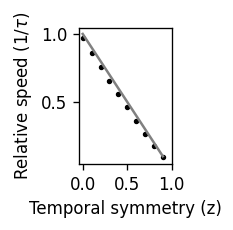

In [105]:
plt.figure(figsize=(1,1.5), dpi=120)
tau = 10
plt.scatter(z, tau/np.asarray([speed(q_ext[i]) for i in np.arange(z.size)]), s=5, color='black');
plt.plot(z, tau/(tau/(1-z)), linestyle='solid', color='grey')
plt.xticks([0,0.5,1]);
plt.ylabel(r"Relative speed ($1/\tau$)")
plt.xlabel("Temporal symmetry (z)")
plt.savefig("1c.pdf", dpi=150, bbox_inches='tight')